# Module Thesis: Predicting short-run exchange rates with macroeconomic variables (Group V)

**Zurich University of Applied Sciences\
School of Management and Law\
Master's Degree Program in Banking and Finance**

**Advanced Quantitative Methods - FS 2022**

**Author:**\
Milasta, Nico: milasnic@students.zhaw.ch \
Schädler, Susan: schaesu1@students.zhaw.ch \
Vangsted, Tobias: vangstob@students.zhaw.ch

**Supervisor:**\
Dr. Tomasz Orpiszewski

***
## Task 12
Create a repository on GitHub or Google Collaboratory. Upload a small piece of your notebook and a small dataset, make sure that the notebook commands are executed in the cloud. Provide the link and a snapshot.

In [1]:
# Import Modules
# Data
import pandas as pd
import sqlite3 as db
from datetime import datetime

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# statistics
import numpy as np
import scipy as sp
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.regression.rolling import RollingOLS
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.stattools import jarque_bera
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.tsa.stattools import acf

In [4]:
# Pull data from db and format
conn = db.connect("aqm_study_db.db")
df = pd.read_sql_query("select * from Base_Data", conn)
conn.close()

df = pd.pivot(df, index="RIC", columns="RIC_Date", values="RIC_Value")

df.index = pd.to_datetime(df.index.values, format="%Y-%m-%d")
df.head()

RIC_Date,AU10YT=RR,AU1YT=RR,AUD=,CH10YT=RR,CH1YT=RR,CHF=,EU10YT=RR,EU1YT=RR,EUR=,GB10YT=RR,...,aUSOCS005Q/A,aUSRSLS/A,aUSSHRPRCF,aUSTBALEU,aUSTBALJP,aUSTBALWEU,aXZCCPIE/CA,aXZCMS1B/A,aXZCPPIE/CA,aXZRSLS/A
2008-10-31,5.160,4.140,0.6676,2.782,3.86,1.1576,3.903,2.692,1.2730,4.510,...,96.73295,3.148300e+11,9325.01,-9.206696e+09,-6.137119e+09,-1.122878e+10,98.807600,5.063615e+12,103.632749,96.9
2008-11-30,4.580,2.890,0.6548,2.241,1.87,1.2134,3.265,1.693,1.2695,3.773,...,96.45727,3.013320e+11,8829.04,-5.891073e+09,-5.050176e+09,-6.981105e+09,98.433016,5.038305e+12,101.874145,96.2
2008-12-31,3.985,2.890,0.7073,2.228,0.98,1.0669,2.949,1.820,1.3978,3.017,...,96.44925,2.940250e+11,8776.39,-6.869932e+09,-5.311482e+09,-7.447885e+09,98.155118,5.581427e+12,100.714485,95.4
2009-01-31,4.103,2.595,0.6350,2.229,1.18,1.1607,3.296,1.272,1.2780,3.702,...,96.45699,2.986730e+11,8000.86,-3.520943e+09,-4.189446e+09,-4.111764e+09,98.141024,5.227782e+12,99.434302,94.2
2009-02-28,4.403,2.750,0.6398,2.282,1.03,1.1706,3.109,0.952,1.2668,3.640,...,96.42902,2.976310e+11,7062.93,-3.299632e+09,-2.209144e+09,-3.645477e+09,98.344009,5.233813e+12,98.767506,93.4


In [5]:
# Transform Data
rics_var = {"FX_Rate":  ["EUR=", "JPY=", "GBP=", "CHF=", "AUD="],
            "Yield_1Y": ["US1YT=RR", "EU1YT=RR", "JP1YT=RR", "GB1YT=RR", "CH1YT=RR", "AU1YT=RR"],
            "Yield_10Y":    ["US10YT=RR", "EU10YT=RR", "JP10YT=RR", "GB10YT=RR", "CH10YT=RR", "AU10YT=RR"],
            "Financial_Market":    ["aUSSHRPRCF", "aFRSHRPRCF/C", "aJPSHRPRCF", "aGBSHRPRCF", "aCHSHRPRCF/C", "aAUSHRPRCF/C"],
            "CPI":  ["aUSCCPIE/CA", "aXZCCPIE/CA", "aJPCCPIE/CA", "aGBCCPIE/CA", "aCHCCPIE/CA", "aAUCCPIE/CA"],
            "PPI":  ["aUSCPPIE/CA", "aXZCPPIE/CA", "aJPCPPIE/CA", "aGBCPPIE/CA", "aCHCPPIE/CA", "aAUCPPIE/CA"],
            "CCI":  ["aUSOCS005Q/A", "aEKOCS005Q/A", "aJPCONCF/A", "aGBOCS005Q/A", "aAURMCONFR"],
            "Retail_Sales": ["aUSRSLS/A", "aXZRSLS/A", "aJPRSLS/A", "aGBRSLS/A", "aCHRSLS/CA", "aAURSLSM/A"],
            "Trade_Balance":    ["aUSTBALEU", "aUSTBALJP", "aUSTBALWEU", "aUSBTPCASA"],
            "Gold": ["XAU="],
            "Money_Supply": ["aUSCMS1B/A", "aXZCMS1B/A", "aJPCMS1B/A", "aGBCMS1B/A", "aCHCMS1B/A", "aAUCMS1B/A"]
            }

In [6]:
# Normalize CCI
# Adjust Japan and Australia according to OECD CONSUMER CONFIDENCE INDICATORS
# https://www.oecd.org/sdd/leading-indicators/45430429.pdf
for i in ["aJPCONCF/A", "aAURMCONFR"]:
    cycle, trend = sm.tsa.filters.hpfilter(df[i], 1)
    df[i] = trend

df[rics_var["CCI"]] = df[rics_var["CCI"]].apply(lambda x: (x-x.mean())/x.std()+100)

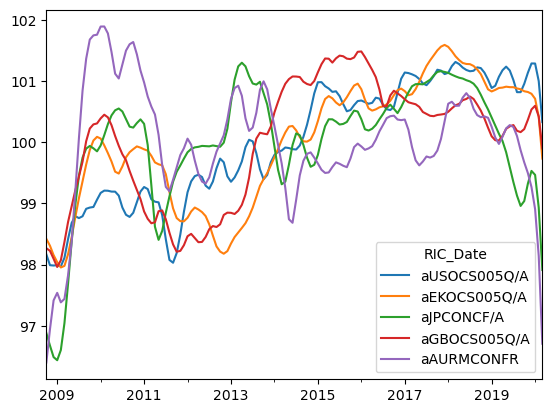

In [7]:
# Plot normalised CCI
df[rics_var["CCI"]].plot()
plt.show()